# CSCO Time Series

This code implements an LSTM (Long Short-Term Memory) model for predicting the stock prices of Cisco Systems (CSCO) using time series data. The code utilizes historical stock data of the New York Stock Exchange and trains an LSTM model to learn patterns and make predictions on a validation set. The model's performance is evaluated using the Root Mean Square Error (RMSE) metric. The code also includes data loading, cleaning, exploratory data analysis (EDA), and model saving steps.

# Import Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab

from math import sqrt, ceil
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from pmdarima import auto_arima
import pickle


## Data Loading and Cleaning

In [12]:
# Read the CSV file into a DataFrame
df = pd.read_csv('stock_raw.csv')

# Display the first few rows of the DataFrame
df.head()

,date,year,month,day,symbol,Security,GICS Sector,GICS Sub Industry,open,close,low,high,volume,price_direction
0,2016-01-05,2016,1,5,WLTW,Willis Towers Watson,Financials,Insurance Brokers,123.430000,125.839996,122.309998,126.250000,2163600.0,2.409996
1,2016-01-06,2016,1,6,WLTW,Willis Towers Watson,Financials,Insurance Brokers,125.239998,119.980003,119.940002,125.540001,2386400.0,-5.259995
2,2016-01-07,2016,1,7,WLTW,Willis Towers Watson,Financials,Insurance Brokers,116.379997,114.949997,114.930000,119.739998,2489500.0,-1.430000
3,2016-01-08,2016,1,8,WLTW,Willis Towers Watson,Financials,Insurance Brokers,115.480003,116.620003,113.500000,117.440002,2006300.0,1.140000
4,2016-01-11,2016,1,11,WLTW,Willis Towers Watson,Financials,Insurance Brokers,117.010002,114.970001,114.089996,117.330002,1408600.0,-2.040001


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               851264 non-null  object 
 1   year               851264 non-null  int64  
 2   month              851264 non-null  int64  
 3   day                851264 non-null  int64  
 4   symbol             851264 non-null  object 
 5   Security           851264 non-null  object 
 6   GICS Sector        851264 non-null  object 
 7   GICS Sub Industry  851264 non-null  object 
 8   open               851264 non-null  float64
 9   close              851264 non-null  float64
 10  low                851264 non-null  float64
 11  high               851264 non-null  float64
 12  volume             851264 non-null  float64
 13  price_direction    851264 non-null  float64
dtypes: float64(6), int64(3), object(5)
memory usage: 90.9+ MB


In [14]:
df.duplicated().sum()

0

No duplicates and no missing values.

In [15]:
# Change date to datetime
df['date'] = pd.to_datetime(df['date'])

In [16]:
# Convert DataFrame's index into a DatetimeIndex
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [17]:
df.tail(10)

,year,month,day,symbol,Security,GICS Sector,GICS Sub Industry,open,close,low,high,volume,price_direction
date,,,,,,,,,,,,,
2016-12-30,2016,12,30,XRAY,Dentsply Sirona,Health Care,Health Care Supplies,58.290001,57.730000,57.540001,58.360001,949200.0,-0.560001
2016-12-30,2016,12,30,XRX,Xerox Corp.,Information Technology,IT Consulting & Other Services,8.720000,8.730000,8.700000,8.800000,11250400.0,0.010000
2016-12-30,2016,12,30,XYL,Xylem Inc.,Industrials,Industrial Conglomerates,49.980000,49.520000,49.360001,50.000000,646200.0,-0.460000
2016-12-30,2016,12,30,YHOO,Yahoo Inc.,Information Technology,Internet Software & Services,38.720001,38.669998,38.430000,39.000000,6431600.0,-0.050003
2016-12-30,2016,12,30,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants,63.930000,63.330002,63.160000,63.939999,1887100.0,-0.599998
2016-12-30,2016,12,30,ZBH,Zimmer Biomet Holdings,Health Care,Health Care Equipment,103.309998,103.199997,102.849998,103.930000,973800.0,-0.110001
2016-12-30,2016,12,30,ZION,Zions Bancorp,Financials,Regional Banks,43.070000,43.040001,42.689999,43.310001,1938100.0,-0.029999
2016-12-30,2016,12,30,ZTS,Zoetis,Health Care,Pharmaceuticals,53.639999,53.529999,53.270000,53.740002,1701200.0,-0.110000
2016-12-30,2016,12,30,AIV,Apartment Investment & Mgmt,Real Estate,REITs,44.730000,45.450001,44.410000,45.590000,1380900.0,0.720001


In [18]:
df['year'].unique()

array([2016, 2010, 2011, 2012, 2013, 2014, 2015])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   year               851264 non-null  int64  
 1   month              851264 non-null  int64  
 2   day                851264 non-null  int64  
 3   symbol             851264 non-null  object 
 4   Security           851264 non-null  object 
 5   GICS Sector        851264 non-null  object 
 6   GICS Sub Industry  851264 non-null  object 
 7   open               851264 non-null  float64
 8   close              851264 non-null  float64
 9   low                851264 non-null  float64
 10  high               851264 non-null  float64
 11  volume             851264 non-null  float64
 12  price_direction    851264 non-null  float64
dtypes: float64(6), int64(3), object(4)
memory usage: 90.9+ MB


In [20]:
csco_df = df[df['symbol'] == 'CSCO']
csco_df.head()

,year,month,day,symbol,Security,GICS Sector,GICS Sub Industry,open,close,low,high,volume,price_direction
date,,,,,,,,,,,,,
2010-01-04,2010,1,4,CSCO,Cisco Systems,Information Technology,Networking Equipment,24.110001,24.690001,24.010000,24.840000,59853700.0,0.580000
2010-01-05,2010,1,5,CSCO,Cisco Systems,Information Technology,Networking Equipment,24.600000,24.580000,24.379999,24.730000,45124500.0,-0.020000
2010-01-06,2010,1,6,CSCO,Cisco Systems,Information Technology,Networking Equipment,24.540001,24.420000,24.340000,24.740000,35715700.0,-0.120001
2010-01-07,2010,1,7,CSCO,Cisco Systems,Information Technology,Networking Equipment,24.299999,24.530001,24.170000,24.570000,31531200.0,0.230002
2010-01-08,2010,1,8,CSCO,Cisco Systems,Information Technology,Networking Equipment,24.379999,24.660000,24.250000,24.700001,39115900.0,0.280001


In [21]:
csco_df = csco_df.drop(['year', 'month', 'day', 'symbol', 'Security', 'GICS Sector', 'GICS Sub Industry', 'open', 'low', 'high', 'volume', 'price_direction'], axis=1)

## EDA

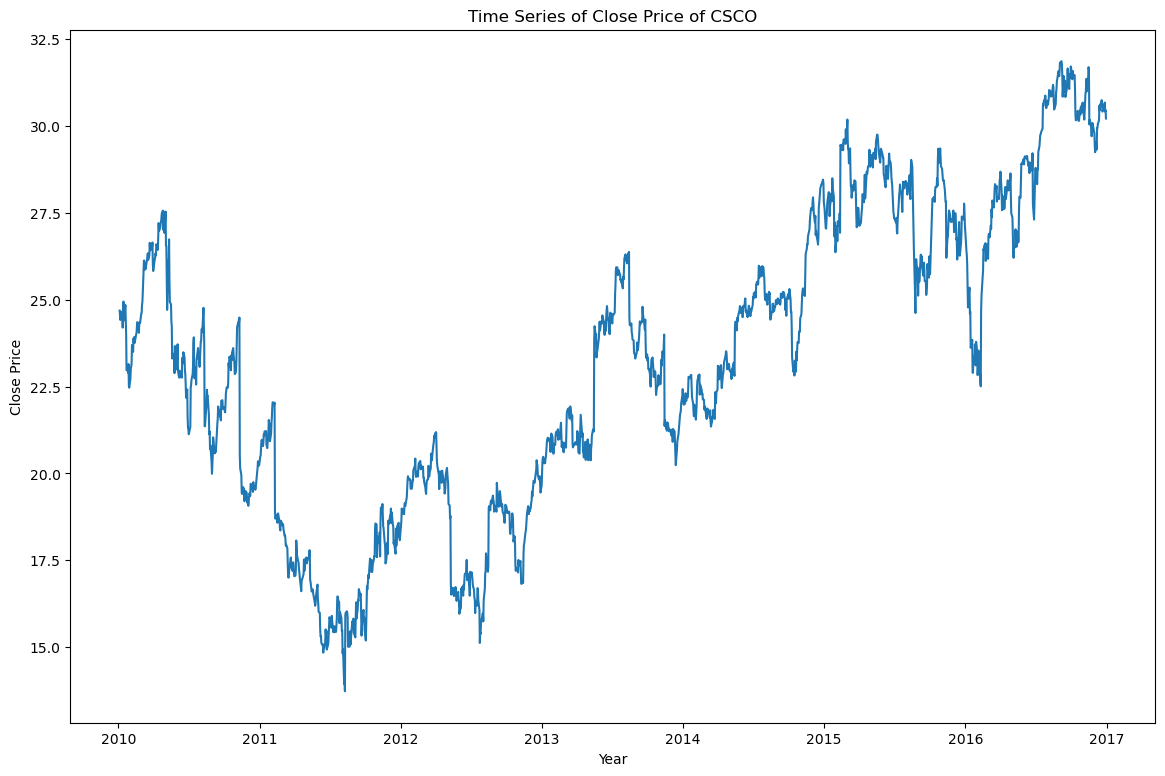

In [28]:
# Plot the time series
plt.figure(figsize=(14, 9))
plt.plot(csco_df.index, csco_df['close'])
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.title('Time Series of Close Price of CSCO')
plt.show()

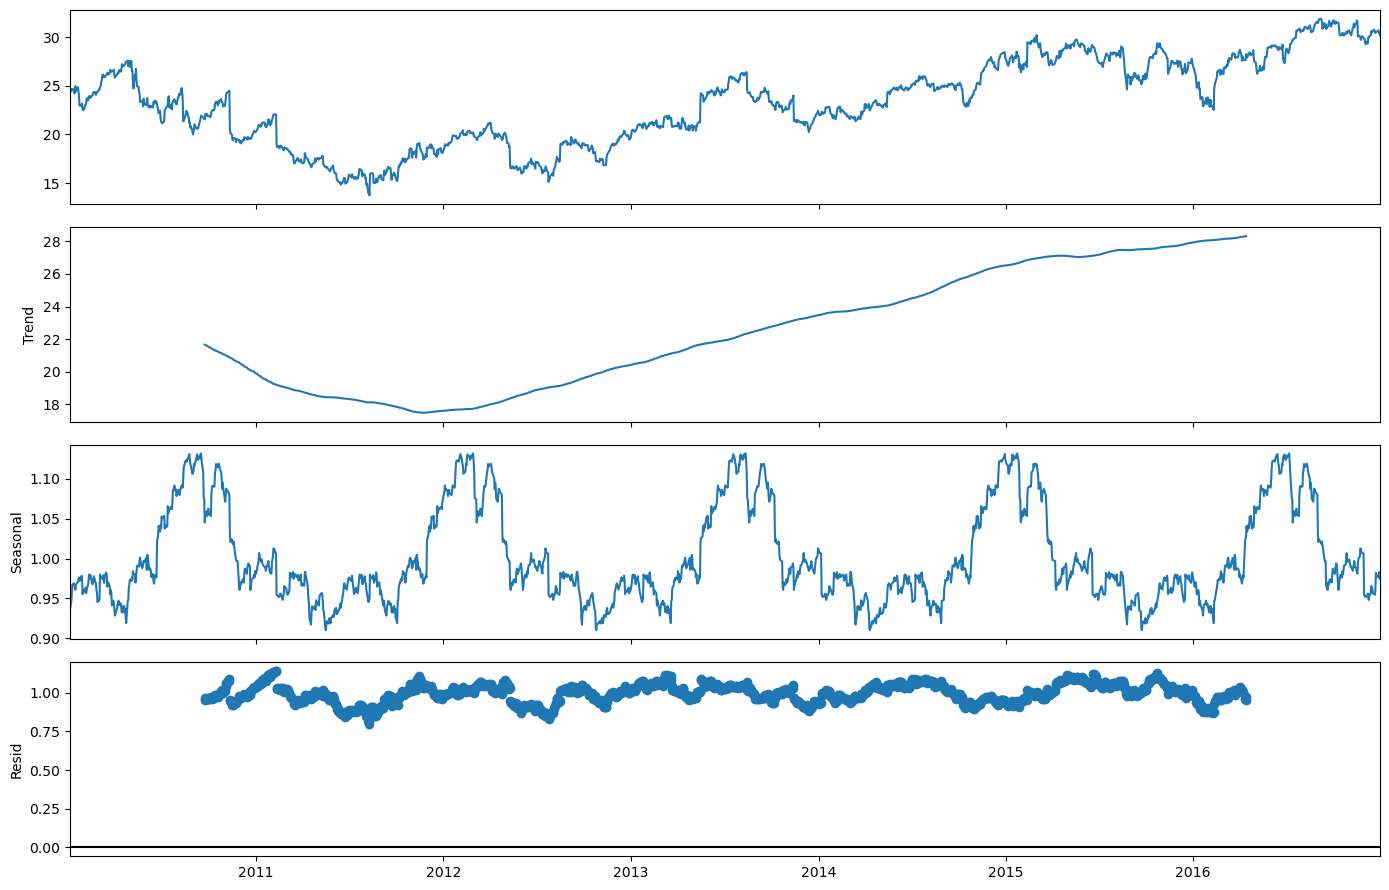

In [23]:
# Decompose the components from the time series
pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(csco_df, model='multiplicative', period=365)
ax = res.plot()
plt.show()

We've adjusted the period to be 365 for yearly seasonality

# Model Selection

## LSTM

In [24]:
shape = csco_df.shape[0]
csco_df=csco_df[['close']]
dataset = csco_df.values
train = csco_df.iloc[:ceil(shape * 0.9)]
valid = csco_df.iloc[ceil(shape * 0.9):]
print('-----------------------------------------------------------------------------')
print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
print('-----------------------------------------------------------------------------')
print('Shape of Training Set',train.shape)
print('Shape of Validation Set',valid.shape)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(csco_df)
# Create the training dataset
x_train, y_train = [], []
for i in range(40,len(train)):
    x_train.append(scaled_data[i-40:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# Train the model
model.fit(x_train, y_train, epochs=15, batch_size=1, verbose=2)

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set (1586, 1)
Shape of Validation Set (176, 1)
Epoch 1/15


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1546/1546 - 12s - 8ms/step - loss: 0.0031
Epoch 2/15
1546/1546 - 9s - 6ms/step - loss: 0.0012
Epoch 3/15
1546/1546 - 9s - 6ms/step - loss: 8.0688e-04
Epoch 4/15
1546/1546 - 10s - 6ms/step - loss: 7.4772e-04
Epoch 5/15
1546/1546 - 10s - 6ms/step - loss: 7.3533e-04
Epoch 6/15
1546/1546 - 9s - 6ms/step - loss: 7.2450e-04
Epoch 7/15
1546/1546 - 9s - 6ms/step - loss: 6.4147e-04
Epoch 8/15
1546/1546 - 9s - 6ms/step - loss: 5.9569e-04
Epoch 9/15
1546/1546 - 9s - 6ms/step - loss: 6.2713e-04
Epoch 10/15
1546/1546 - 9s - 6ms/step - loss: 6.1416e-04
Epoch 11/15
1546/1546 - 9s - 6ms/step - loss: 6.1568e-04
Epoch 12/15
1546/1546 - 9s - 6ms/step - loss: 5.7805e-04
Epoch 13/15
1546/1546 - 9s - 6ms/step - loss: 5.6588e-04
Epoch 14/15
1546/1546 - 9s - 6ms/step - loss: 6.0016e-04
Epoch 15/15
1546/1546 - 9s - 6ms/step - loss: 5.7597e-04


In [25]:
# Prepare the validation dataset
inputs = csco_df[len(csco_df) - len(valid) - 40:]
inputs
inputs.values.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(40,inputs.shape[0]):
    X_test.append(inputs[i-40:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# Generate predictions
closing_price = model.predict(X_test)
closing_price= scaler.inverse_transform(closing_price)
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print('RMSE value on validation set:',rms)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
RMSE value on validation set: 0.3448508278260624


/var/folders/04/6fqt654n63g074w0l8j38g3w0000gn/T/ipykernel_70215/1453454608.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


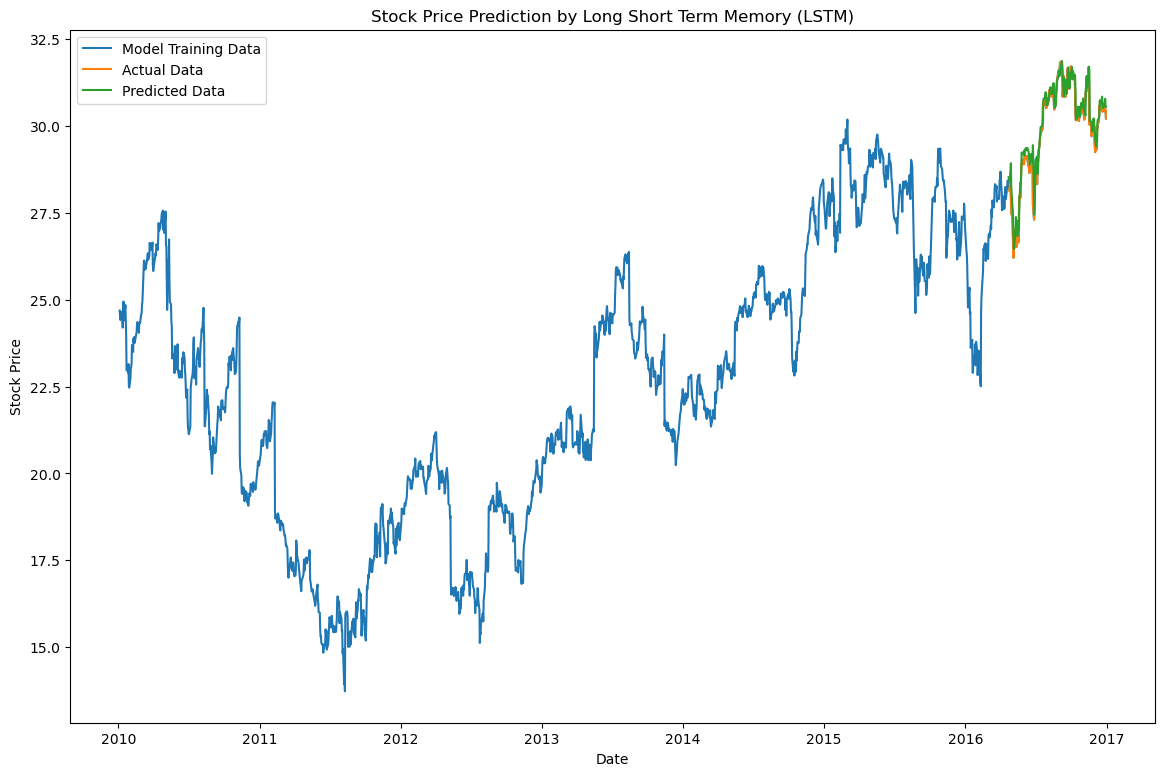

In [26]:
#Visualize the prediction
plt.figure(figsize=(14,9), dpi=100)
valid['Predictions'] = closing_price
plt.plot(csco_df['close'])
plt.plot(valid[['close','Predictions']])
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)')
plt.legend(['Model Training Data','Actual Data','Predicted Data'])

The code encompasses several crucial steps in the process of predicting stock closing prices using an LSTM (Long Short-Term Memory) model. Initially, it prepares the data by cleaning and organizing it into a suitable format for analysis. Following this, the data undergoes scaling to ensure all features are on a comparable scale, which is essential for optimal model performance. The code then creates sequences from the scaled data, structuring it in a way that allows the LSTM model to learn patterns over time.

Once the data is properly prepared, the LSTM model is trained using these sequences. The model learns to recognize patterns in the historical stock data and uses this knowledge to make predictions. After the training phase is complete, the code moves on to the evaluation stage. Here, it utilizes the trained model to predict closing prices on a separate validation set, which consists of data the model hasn't seen during training.

To quantify the model's performance, the code calculates the Root Mean Square Error (RMSE) between the predicted closing prices and the actual closing prices in the validation set. This RMSE value serves as a measure of the model's accuracy, providing insight into how well the LSTM model can predict future stock prices based on historical data.

# Model Saving

In [27]:
# Save lstm model
model.save('csco_lstm_model.h5')